# Synthetic Control Bias and Correction with K-Folds
Julian Hsu
19 Oct 2022

This notebook find the bias in standard SC models, and implements the K-Fold procedure from  [Chernozhukov, Wuthrich, and Zhu (2022)](https://arxiv.org/pdf/1812.10820.pdf)  to correct this.

### Table of Contents
1. K-Fold SC Procedure Overview
2. Class of Functions for DGP and SC
3. Simulation of Bias
4. Implementation of K-Fold SC

## K-Fold SC Procedure Overview
This comes from the [Chernozhukov, Wuthrich, and Zhu (2022)](https://arxiv.org/pdf/1812.10820.pdf) paper about using a generalized K-fold procedure to estimate an SC model and do inference.

We first divide the panel data of pre-treatment data into $K$ consecutive time periods where each block (or fold) is $H_k$ periods. Where $H_k$ has the length $r = min\{ \frac{T_0}{K}, T_1 \}$ . $T_0$ is the number of pre-treatment periods and $T_1$ is the number of post-treatment periods. We then run a SC model on each block (or fold) and use it to estimate the counterfactual on all other blocks. That is, for $k=1,...,K$ we estimate a different ATET:

$$\hat{\tau}_k = \dfrac{1}{T_1} \sum^T_{t=T_0+1} \big( Y_{0t} - \sum^N_{i=1} \hat{\omega_{i,(k)}} Y_{it} \big) - \dfrac{1}{|H_k|}\sum_{t \in H_k} \big( Y_{0t} - \sum^N_{i=1} \hat{\omega_{i,(k)}} Y_{it} \big) $$
$$\hat{\tau} = \dfrac{1}{K}\sum^K_{k=1} \hat{\tau}_k$$
Where $\hat{\omega_{i,(k)}} $ is obtained by training the SC model on the data not in block $k$.

Note that the first summation is the standard SC model with the observed treated's post-treatment outcome $Y_{0t}$ minus the estimated counterfactual based on the estimated weights applied to the controls' post-treatment outcome. The risk is that this paper shows the estimator is biased, and can be corrected by doing the same comparison by for the *pre-treatment* periods.

Where does this bias come from? If the data is high-dimensional by having a lot of time periods $T_0 >> N$, then you can have an error from estimation. 

This K-fold model also offers standard errors that do not depend on a Long-Run Variance (LRV). The t-statistic of K-fold model estimator is:

$$\mathbb{T}_K = \dfrac{\sqrt{K}(\hat{\tau} - \tau_0 )}{ \hat{\sigma}_{\hat{k}} }$$
$$\text{  where  } \hat{\sigma}_{\hat{k}} = \sqrt{1 + \frac{K \cdot r}{T_1}} \sqrt{\frac{1}{K-1} \sum^K_{k=1}(\hat{\tau}_k  -\hat{\tau} )^2   }   $$

From here, we can construct a $(1-\alpha)$ confidence interval:

$$CI_K(1-\alpha) = \hat{\tau} \mp \mathbb{cv}(1-\alpha/2) \cdot \frac{\hat{\sigma}_k}{\sqrt{K}}  $$
where $\mathbb{cv}(1-\alpha/2)$ is the $(1-\alpha/2)$-th quantile of the t distribution with $K-1$ degrees of freedom.

## Class of Functions for DGP and SC
### DGP
We will have a function, `panel_station` which outputs multiple types of outcomes following [Chernozhukov et al.'s $\tau$-test SC paper, (2018)](https://arxiv.org/abs/1812.10820).

Stationary Trend:
$$Y_{it} = \lambda_i f_t + \eta_{it} $$
Non-Stationary Trend with a random walk:
$$Y_{it} = \theta_{t} +  \lambda_i f_t + \eta_{it} $$
Non-Stationary Trend with a random walk and sparse deviation:
$$Y_{it} = \theta_{1t} + 1\{i=1\}\theta_{2t}  \lambda_i f_t + \eta_{it} $$
Heterogeneous Trends:
$$Y_{it} = \theta_{it} +  \lambda_i f_t + \eta_{it} $$

where
$$\eta_{it} = \rho_i \eta_{it-1} + \epsilon_{it}, \epsilon_{it} \sim N(0,\sigma^2_\epsilon) $$
$$f_t \sim N(0, \sigma^2_f) $$
$$\theta_t = \theta_{t-1} + \xi_t , \xi_t \sim N(0,1)$$
$$\theta_{1t} = \theta_{1t-1} + \xi_{1t}, \xi_{1t} \sim N(0,1) $$
$$\theta_{2t} = \theta_{2t-1} + \xi_{2t}, \xi_{1t} \sim N(0,1) $$
$$\theta_{it} = i + i \cdot t$$
### SC Models
For simplicity, focus on the Abadie, Diamond, Hainmueller (2010) SC. 

In [74]:
import pandas as pd
import numpy as np
import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import display    

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

In [75]:
class dgp:    
    def panel_station(seed_number = 2739,
                     pre_time_units = 20,
                     pst_time_units = 5,
                     x_units_control = 15,
                     x_units_treat = 5,                      
                     K_dim = 5,
                     at = 2):
        '''
        seed_number  random_number_set
        pre_time_units   how many pre-treatment time periods?
        pst_time_units   how many post-treatment time periods?
        x_units      how many units?
        K_dim        how many covariates (assume uniform)
        at           ATET estimate
        '''  
        xfun = np.random.RandomState(seed_number)
        time_units = pre_time_units + pst_time_units
        t_range = pd.date_range(pd.to_datetime('2020/01/01'), periods=time_units, freq="M")
        x_units = x_units_control+x_units_treat
        u_range = range(x_units)
        sigma_epsilon = 1
        rho = 0.75


        df_return = pd.DataFrame(index=list(u_range)*time_units, 
                     columns=['date'],
                     data= np.array( [ [p]*x_units for p in t_range] ).flatten() )
        df_return.reset_index(names='unitid', inplace=True)

        df_return.sort_values(by=['unitid','date'], ascending=True, inplace=True)
        df_return['_f'] = np.log( 1+df_return.groupby('unitid').rank() )

        ## Lambda is time-invariant
        df_return['_lambda'] = xfun.uniform(0,1, len(df_return) )
        df_return['_lambda'] = df_return.groupby('unitid')['_lambda'].mean()
        df_return['_lambda'] = df_return['_lambda'].fillna(df_return.groupby('unitid')['_lambda'].transform('mean'))

        ## eta is lagged
        df_return['_eta'] = xfun.normal(0, sigma_epsilon, len(df_return))
        df_return['_eta'] = df_return.groupby('unitid').shift(1)['_eta'].fillna(0)*rho + df_return['_eta']

        ## xi is unit-invariant
        ## create unit-invariant AR values
        def ar1(error_name, theta_name):
            df_return[error_name] = xfun.normal(0, 1, len(df_return))
            df_return[error_name] = df_return.groupby('unitid')[error_name].mean()
            df_return[error_name] = df_return[error_name].fillna(df_return.groupby('unitid')[error_name].transform('mean'))
            df_return[theta_name] = df_return.groupby('unitid').shift(1)[error_name].fillna(0)*rho + df_return[error_name]
        ar1('_xi', '_theta_t')    
        ar1('_xi1', '_theta_t1')    
        ar1('_xi2', '_theta_t2')    

        ## Allow _theta_t2 to be sparse
        ## It is allowed to be non-zero for only one unit
        random_unit = xfun.choice(x_units,1)[0]
        df_return.loc[df_return['unitid']!=random_unit, '_theta_t2'] = 0

        ## heterogeneous trends
        df_return['_theta_it'] = (df_return['unitid']+1) + np.log(df_return['unitid']+1)*df_return['_f']
        ## Assign treatment status
        df_return['treated_unit'] = (df_return['unitid'].isin(np.arange(x_units_treat))).astype(float)
        df_return['post'] = (df_return['date'].isin(t_range[-1*pst_time_units:])).astype(float)
        df_return['W'] =     df_return['treated_unit']*    df_return['post']
        ## Assign outcome ot treated values
        df_return['y_station']      = df_return['W']*at + df_return['_lambda'] * df_return['_f'] + df_return['_eta']
        df_return['y_nonstation_rw']= df_return['W']*at + df_return['y_station'] + df_return['_theta_t']
        df_return['y_nonstation_rw_sparse'] = df_return['W']*at + df_return['y_station'] + df_return['_theta_t1'] + df_return['_theta_t2']
        df_return['y_nonstation_het']       = df_return['W']*at + df_return['y_station'] + df_return['_theta_it']
        
        df_return['unitid'] = df_return['unitid'].apply(str)        
        return df_return
    
    def clean_and_input_data(dataset=None, 
                             treatment='treated_unit', 
                             date='T',
                             post='post', outcome='Y'):
        
        C_pre = dataset.loc[(dataset[treatment]==0) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        C_pst = dataset.loc[(dataset[treatment]==0) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        T_pre = dataset.loc[(dataset[treatment]==1) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        T_pst = dataset.loc[(dataset[treatment]==1) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        return {'C_pre':C_pre, 'C_pst':C_pst, 'T_pre':T_pre, 'T_pst':T_pst}    

In [76]:
## Also code up the ADH weights
## Abadie/Diamond/Hainmueller    
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

class adh:
    ## Define loss function
    def loss_w(W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    def get_w(X, y):
        ## Initialize at sample average with some noise
        w_start = [1/X.shape[1]]*X.shape[1]+np.random.uniform(-0.005,0.005, X.shape[1])
    #     w_start = np.ones(X.shape[1])

        weights = fmin_slsqp(partial(adh.loss_w, X=X, y=y),
                             np.array(w_start),
                             f_eqcons=lambda x: np.sum(x) - 1,
                             iter=50000, 
                             bounds=[(0.0, 1.0)]*len(w_start),
                             disp=False)
        return weights   
    
    def predict_omega(treatment_pre, control_pre, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]]
        treatment_holdout = treatment_pre[0:holdout_windows[0]]    
        
        control_nonholdout = control_pre[holdout_windows[0]:]
        treatment_nonholdout = treatment_pre[holdout_windows[0]:]
        
        ## Estimate the CL model
        ## Let's loop over different treatment units.
        holdout_dict = {}
        holdout_dict['omega'] = []
        holdout_dict['weights'] = []
        diff_holdout_mse = []
        diff_nonholdout_mse = []
        for t in treatment_pre.columns:
            t_dict = adh.get_w(control_holdout,treatment_holdout[t])
            ## Estimate measure of fit for the hold out and non-holdout sample
            diff_h = treatment_holdout[t]       - np.dot(control_holdout, t_dict.T)
            diff_h_mse = (diff_h**2).mean()
            diff_nh = treatment_nonholdout[t] - np.dot(control_nonholdout, t_dict.T)
            diff_nh_mse = (diff_nh**2).mean()

            holdout_dict['omega'].append(t_dict)
            holdout_dict['weights'].append(t_dict)
            diff_holdout_mse.append(diff_h_mse)
            diff_nonholdout_mse.append(diff_nh_mse)

        holdout_dict['omega'] = np.array(holdout_dict['omega'])
        holdout_dict['mse_holdout'] =np.mean(diff_holdout_mse)
        holdout_dict['mse_nonholdout'] =np.mean(diff_holdout_mse)        
        
        return holdout_dict    
    
    def sc_style_results(treatment_pre, treatment_pst, control_pre, control_pst, mu,omega):
        final_X = pd.concat([treatment_pre, treatment_pst], axis=0)
        control_X = pd.concat([control_pre, control_pst], axis=0)

        control_df = mu + pd.DataFrame(data=np.dot(control_X, omega.T), columns=[ l+'_est' for l in final_X.columns ])
        control_df.index = final_X.index
        
        output_df = control_df.join(final_X)
        
        treatment_periods = -1*len(treatment_pst)
        atet_df = pd.DataFrame()
        for c in [l for l in output_df.columns if '_est' not in l]:
            diff = output_df[c][treatment_periods:] - output_df[c+'_est'][treatment_periods:]
            atet_df[c] = diff
        
        return {'atet': atet_df , 'predict_est':output_df}    

## Simulation of Bias

In [78]:
settings ={'atet_gt': 5,
          'T0':20,
          'N':15}
df_sim = pd.DataFrame()
y_outcome = ['y_station', 'y_nonstation_rw']
#              , 'y_nonstation_rw_sparse',
#        'y_nonstation_het']
adh_estimates = []
sim_range = range(500)
t0_range = [5,20,100]
for t0 in t0_range:
    for sim in sim_range:
        df = dgp.panel_station(seed_number=sim,
                         pre_time_units=t0,
                         pst_time_units=5,
                         x_units_control = settings['N'],
                         x_units_treat = 1,
                         K_dim = 3,
                         at=settings['atet_gt'])
        for y_iter in y_outcome:
            ## Clean data
            di_dict = dgp.clean_and_input_data(dataset=df,
                                               treatment='treated_unit', 
                                               date='date',
                                               post='post',
                                              outcome=y_iter)

            ## Create Primitives
            tw =  len(df.loc[ df['W']==1]['date'].unique())
            treatment_window = len(df.loc[(df['W']==0)]['date'].unique())-tw, tw

            time_list = np.arange( np.sum(treatment_window) )
            T_len = len(time_list)

            ## Time block permutations
            permutations_subset_block = []

            for i in range(T_len):
                half_A = time_list[-1*(T_len-i):]
                half_B = time_list[0:i]
                scrambled_list = np.concatenate([half_A, half_B]) 
                permutations_subset_block.append( list(scrambled_list)  )

            treatment_window_pre_treatment = [int(treatment_window[0]*0.75) ,treatment_window[0]-int(treatment_window[0]*0.75)   ]

            ## Run ADH Model
            ao3 = adh.predict_omega(di_dict['T_pre'], di_dict['C_pre'], treatment_window_pre_treatment)
            adh_output = adh.sc_style_results(di_dict['T_pre'], di_dict['T_pst'],
                                di_dict['C_pre'], di_dict['C_pst'],
                                np.zeros(di_dict['T_pst'].shape[1]), np.array(ao3['omega']))
            sim_est=  adh_output['atet'].mean(axis=0).values[0]   
            row = pd.DataFrame(index=[sim], data={'atet':sim_est,
                                   'gt':settings['atet_gt'],
                                   'T0':t0,
                                                  'y':y_iter,
                                   'N':settings['N']})
            df_sim = pd.concat([df_sim, row])

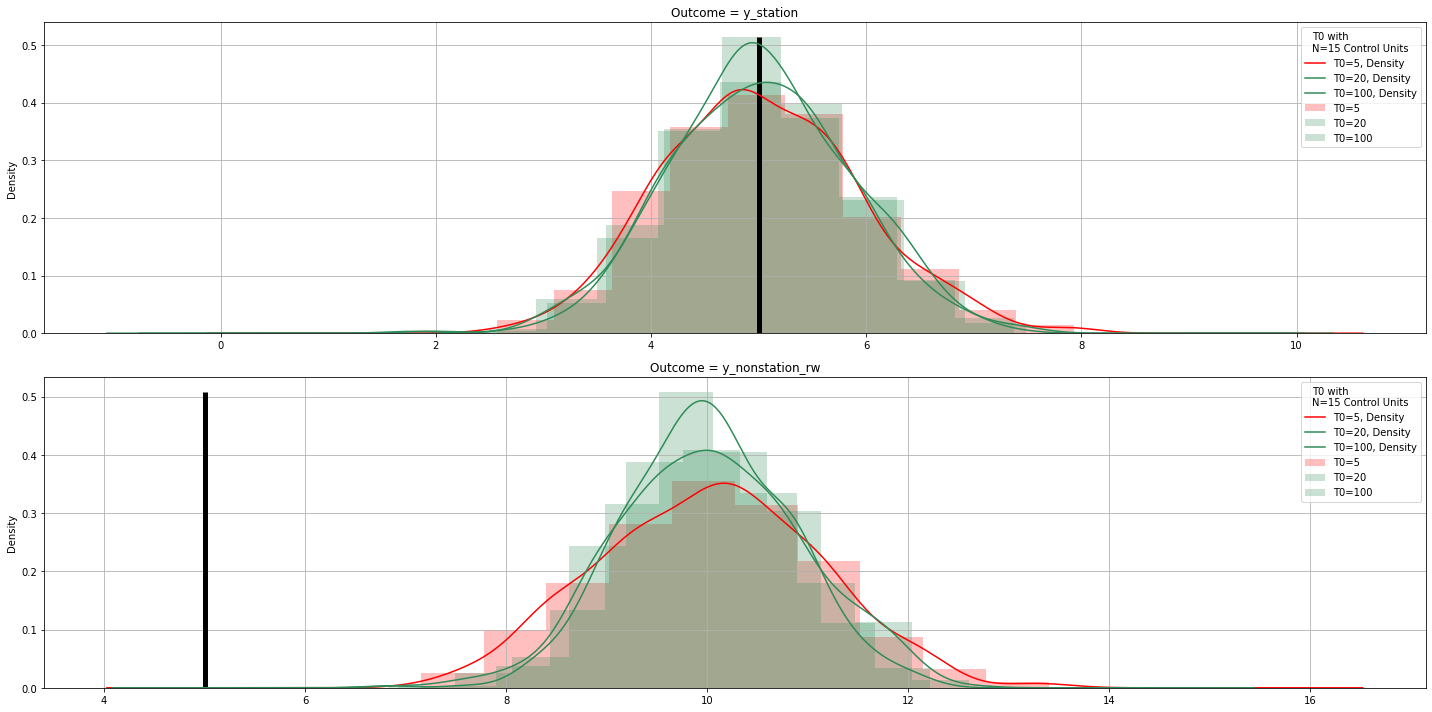

In [79]:
fig,ax = plt.subplots(nrows=len(y_outcome),ncols=1, figsize=(20,10))
for y_i, y_iter in zip(range(len(y_outcome)), y_outcome):
    for t0 in t0_range:
        if t0==5:
            color='red'
        elif t0==10:
            color='royalblue'
        else:
            color='seagreen'
        a = ax[y_i].hist(df_sim.loc[(df_sim['T0']==t0) & (df_sim['y']==y_iter)]['atet'], 
                    density=True, alpha=0.25, color=color,
                   label='T0={0}'.format(t0))
        df_sim.loc[(df_sim['T0']==t0) & (df_sim['y']==y_iter)]['atet'].plot(kind='density',
                                                                            ax=ax[y_i],
                                                                            label='T0={0}, Density'.format(t0),
                                                                           color=color)
        ax[y_i].vlines(x= settings['atet_gt'], 
                       color='black',
                  ymin=0, ymax=a[0].max(),
                  linewidth=5)
    ax[y_i].legend(title='T0 with \nN={0} Control Units'.format(settings['N']))
    ax[y_i].set_title('Outcome = {0}'.format(y_iter))
    ax[y_i].grid()
plt.tight_layout()

In [ ]:
## Implementation of K-Fold SC